# PDF Journalling: How to Revoke your Updates. Part 1: The Basics

## Introduction
Modern database management systems include journalling facilities. This feature allows logging changes to databases in special files, so-called journals or logfiles.

Long-running applications, updating multiple logically interconnected databases, cannot afford to rerstart all over after crashes like power or hardware failures as this would entail restoring all databases  - long-running jobs by themselves.

With a properly created journal, at restarting application will read the logfile and look up the last point at which all involved databases have been in a consistent state (a so-called *checkpoint*), roll back any logged updates thereafter and resume running from that point on.

MuPDF supports a journalling feature which makes the above database concepts available for updating PDFs.

Applications updating databases may now integrate PDF changes in their checkpoint-restart logic.

But independent from any databases, it is also possible to put incremental updates of a PDF under the control of PDF journalling. Together with the journal file, it is possible to reinstate earlier versions of the document.

A note on terminology:
  * Updates to (SQL) databases are grouped in "Logical Units of Work" (LUWs). Consitent database configurations exist at start and end of a LUW. Writing a checkpoint therefore always happens **after** the end of an LUW - never in between. For performance reasons, more than one LUW are usually executed before a checkpoint is written.
  * In MuPDF the term "operation" plays the role of an LUW.

> PDF Journalling is a unique, unequalled feature of PyMuPDF and MuPDF. It allows keeping advanced control over updates to PDF documents, granular undoing changes and an independent way to detect unauthorized changes.

## Part 1: The Basics
In this notebook you will learn basic concepts of PDF journalling using PyMuPDF:
1. How to activate journalling and define opeartions
2. How to make and navigate between changes

In [236]:
"""
Notebook preamble code:
Install and import required packages, define image generation utility.
"""
# Make sure having installed required packages by uncommenting the following lines as required
# !python -m pip install pymupdf
# !python -m pip install matplotlib

import fitz

if tuple(map(int, fitz.VersionBind.split("."))) < (1, 19, 0):
    raise ValueError("Need PyMuPDF v1.19.0 or higher")

def show_image(item, title):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: a PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and uses matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    %matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set titel of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

The actual application code follows here.

We create a new empty PDF and enbale journalling for it.

In [237]:
doc = fitz.open()  # work with an empty PDF
doc.journal_enable()  # enable journalling

After journalling is enabled for a PDF, **_all_** updates are being logged, and therefore must be executed within the scope of some **operation** (called LUW, Logical Unit of Work in database  systems).

We first try an update without having an active operation to see what happens:

In [238]:
try:
    page = doc.new_page()
except Exception as e:
    print(e)

No journalling operation started


Operations are started and stopped via methods `journal_start_op()` and `journal_stop_op()`. Between these statements, any number of updates to the PDF may happen - this is entirely your decision. Undoing an operation will revert all updates within it, so you should plan the design of your operations accordingly.

In the following, we add a new page to the document and wrap it in an operation.

In [239]:
doc.journal_start_op("add new page")  # define start of an operation
page = doc.new_page(width=200, height=150)
doc.journal_stop_op()  # define stop of operation

This time it worked: we have a page. Now insert three lines of text - each within its own operation, so they can be individually undone (rolled back).

> The **name** of an operation is entirely documentary and can be used at your discretion.

In [240]:
for i in range(3):
    doc.journal_start_op(f"add line-{i}")
    # insert next line 20 points below previous one
    page.insert_text((50, 50 + 20*i), "This is line %i." % i)
    doc.journal_stop_op()

### Investigating and Navigating the Journal
PyMuPDF will append all update activity to an internal log, called "journal" (or sometimes also "history").

There are methods that let us investigate the journal content in various ways.
It is possible to navigate up and down inside the journal.

The first information we are interested in: What is our current operation number and what is the total number of operations?

In [241]:
doc.journal_position()  # returns a tuple: (current op number, total op count)

(4, 4)

Okay, so this tells us that the current operation was the fourth out of a total number of four.

How about a list of **_all_** operations so far?

In [242]:
for i in range(doc.journal_position()[1]):  # loop over total number of operations
    print(f"Operation {i}: {doc.journal_op_name(i)}")  # show the operation name

Operation 0: add new page
Operation 1: add line-0
Operation 2: add line-1
Operation 3: add line-2


Given our current position: What can we do inside the journal going forward?

The are always two options:
* **"undo"** - this causes the updates of the current operation to be reverted (undone). Use method `journal_undo()`.
* **"redo"** - this will re-apply the updates of the operation that **_follows_** the current one. Use method `journal_redo()`.

As we are currently positioned at the very last operation, there will be no "next" operation that can be redone. Therefore, we are getting a result to be expected:

In [243]:
doc.journal_can_do()  # what can we do currently?

{'undo': True, 'redo': False}

Let us nevertheless try to redo something:

In [244]:
try:
    doc.journal_redo()
except Exception as e:
    print(e)

Already at end of history


Only undo activities are possible, currently. Let us try one, but first we look at what is on the page:

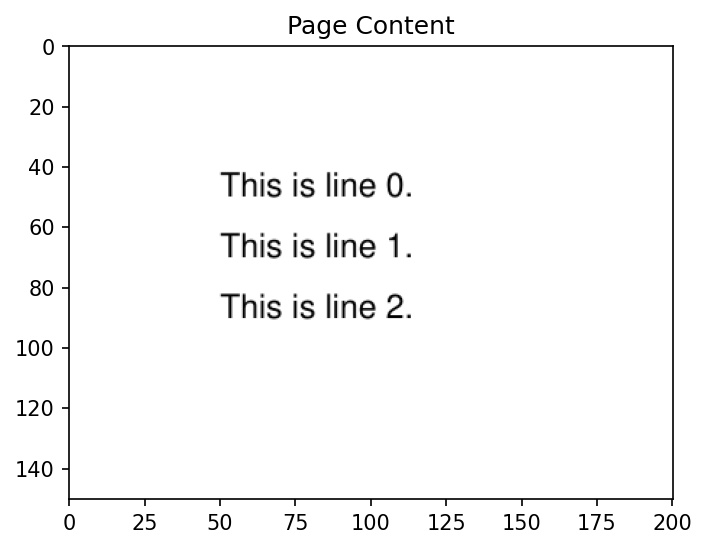

In [245]:
# Display the page image
show_image(page, "Page Content")

Undo the current operation and display the journalling status as above.

In [246]:
doc.journal_undo()  # undo an operation
doc.journal_position()  # where are we in the journal?


(3, 4)

In [247]:
doc.journal_can_do()  # what can we do now?

{'undo': True, 'redo': True}

So, again as expected:
1. Our current position inside the journal is reduced by one - but there are still four entries in it.
2. Now we can do both: *undo* **and** *redo*.

The really interesting thing: what happened to the page content?

If all worked fine, we should see only 2 lines of text.

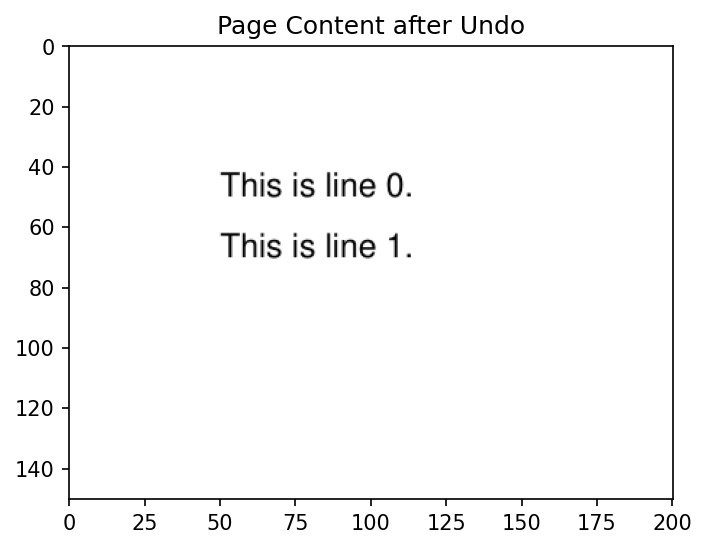

In [248]:
# Display the page image
show_image(page, "Page Content after Undo")

Good! Last text insertion was reverted.

Let us change our mind again and redo (re-apply) the undone operation. This will re-execute everything contained in operation following the current one. In other words, our third text line should be there again afterwards.

In [249]:
doc.journal_redo()  # redo reverted operation

True

Confirm that we have three text lines again:

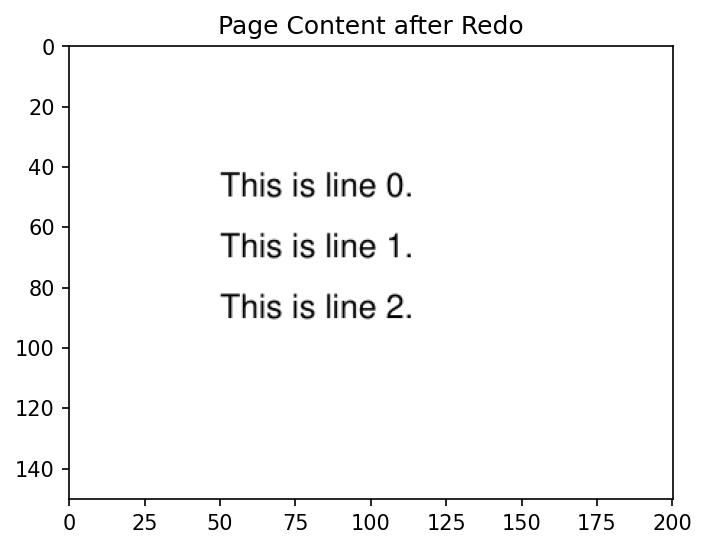

In [250]:
# Display the page image
show_image(page, "Page Content after Redo")

### Wrapping up

* Undoing is only possible for the operation at the current position.
* Redoing re-executes the operation following the current position.
* All operations are kept inside a memory area maintained by MuPDF, called the "journal" or "history".
* All journal data remain available until the PDF is closed.
* Enabling journalling for a PDF cannot be disabled.
* Journal data can be exported to a file (or file-like object).


### Conclusion
In this notebook we have learned the basics about PDF journalling:
* How to enable journalling for a PDF
* How to extract journal information
* How to navigate in the journal and undo or redo operations

### Outlook
This notebook is the first of a series about PDF journalling. There are the following sequels:
* **Part 2:** The notebook will handle more advanced journalling topics, for instance what happens if we update the PDF after an undo. Please find this notebook [here](https://github.com/pymupdf/PyMuPDF-Utilities/blob/master/jupyter-notebooks/journalling2.ipynb).
* **Part 3:** The notebook will cover journalling updates to an **existing PDF**, synchronized saving of journal and PDF, and how to enable journalling for a PDF using a journal file. Please find this notebook [here](https://github.com/pymupdf/PyMuPDF-Utilities/blob/master/jupyter-notebooks/journalling3.ipynb).